# Visualize seasonal jet of Atlantic water

In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, TransformedBbox, BboxPatch, BboxConnector 
from matplotlib.transforms import Bbox
import matplotlib.patches as patches
import cmocean
import pickle
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import ListedColormap
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
import glob
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

%matplotlib inline

#### Parameters:

In [3]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

# Resolution of grid cells to show in figure:
grid_reso  = 10

# Colors:
land_color  = '#a9a7a2'
land_outline_color = '#373736'
color_GS = '#003856';
color_BB = '#0369a0';
color_BI = '#81b4cf';

# transect coordinates:
BB_coords = (1470,1471,515,670) # Baffin Bay
# DS_coords = (1320,1321,538,630) # Davis Strait (jet)
DS_coords = (1290,1291,502,630) # Davis Strait (jet)

month_list = ['Jan.','Feb.','Mar.','Apr.','May','June','July', 'Aug.', 'Sep.','Oct.','Nov.', 'Dec.']
full_month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
                   'August', 'September', 'October', 'November', 'December']

In [4]:
cmap1 = cmocean.cm.balance
cmap1.set_bad(land_color, 1)   

#### Load files:

In [14]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
mask         = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values

# General file:
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_hdept  = mesh['hdept'].values[0,:,:]
mesh_hdepw  = mesh['hdepw'].values[0,:,:]
mesh_mbathy = mesh['mbathy'].values[0,:,:]
mesh_gdepw  = mesh['gdepw_1d'].values[0,:]

In [6]:
# transect coordinates
DS_lons  = mesh_lon[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_lats  = mesh_lat[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_deps  = bathy_masked[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]

#### Functions

In [7]:
def plot_layer(ax, variable, layer, vmin=0, vmax=30, month='', cmap=cmocean.cm.balance):
    cmap2 = cmap
    cmap2.set_bad(land_color, 1)   

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
    
    CB = proj1.pcolormesh(x, y, variable[layer,:,:]*1e12, cmap=cmap2, vmin=vmin, vmax=vmax, ax=ax) 
    ax.set_facecolor(land_color)

    proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], \
               cmap=matplotlib.colors.ListedColormap([land_color]), zorder=1, ax=ax)

    ax.set_title(f'{month}', fontsize=7)
    return CB

In [8]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [9]:
def get_boundary_depths(bdy_distance, bdy_ind, cell=0):
    
    model_depths    = np.zeros((len(mesh_depth), len(bdy_distance)))
    for n in range(0,len(bdy_distance)):         
        mesh_depth_adjusted = np.copy(mesh_gdepw)
        if (bdy_ind[1]-bdy_ind[0]) < (bdy_ind[3]-bdy_ind[2]): # depending on orientation of boundary
            bathy_ind           = mesh_mbathy[bdy_ind[0]+cell, bdy_ind[2]+n]
            mesh_depth_adjusted[0:int(bathy_ind)+1]  = mesh_hdept[bdy_ind[0]+cell, bdy_ind[2]+n]
        else:
            bathy_ind           = mesh_mbathy[bdy_ind[0]+n, bdy_ind[2]+cell]
            mesh_depth_adjusted[0:int(bathy_ind)+1]  = mesh_hdept[bdy_ind[0]+n, bdy_ind[2]+cell]

        model_depths[:,n]    = mesh_depth_adjusted
    
    return model_depths

In [10]:
def land_patch(distances, coordi, coordj):
    
    topo = []
    for d, distance in enumerate(distances[0:-1]):
        rect = Rectangle((distance, mesh_hdepw[coordi,coordj+d]), distances[d+1]-distance, 5000)
        topo.append(rect)

    pc = PatchCollection(topo, facecolors=land_color, edgecolors=land_color, alpha=1)
    return pc

#### Calculations

In [11]:
DS_distance  = calc_distance(DS_lats, DS_lons) 

In [15]:
DS_model_depths = get_boundary_depths(DS_distance, DS_coords,  cell=0)

In [16]:
folder1 = f'/data/brogalla/run_storage/Pb-reference-202303/'
comp1   = xr.open_dataset(f'{folder1}climatology-2007-onwards.nc')
comp2   = xr.open_dataset(f'{folder1}climatology-LS-2007-onwards.nc')
dPb_ref = comp1['dissolpb'].values[:,0,:,:,:]
dPb_LS  = comp2['dissolpb'].values[:,0,:,:,:]

In [17]:
delta_dPb         = (dPb_LS - dPb_ref).mean(axis=0) # initially look at mean over full time series, not monthly
delta_dPb_monthly = (dPb_LS - dPb_ref)

#### Figure:

In [18]:
def mark_inset(ax, ax2, m, m2, loc1=(2, 2), loc2=(3, 4), mark_connecter=True, **kwargs):
    """
    Patched mark_inset to work with Basemap.
    Reason: Basemap converts Geographic (lon/lat) to Map Projection (x/y) coordinates

    Additionally: set connector locations separately for both axes:
        loc1 & loc2: tuple defining start and end-locations of connector 1 & 2
    """

    axzoom_geoLims = m2(ax2.get_xlim(), ax2.get_ylim(), inverse=True)
    rect = TransformedBbox(Bbox(np.array(m(*axzoom_geoLims)).T), ax.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    ax.add_patch(pp)

    if mark_connecter:
        p1 = BboxConnector(ax2.bbox, rect, loc1=loc1[0], loc2=loc1[1], **kwargs)
        ax2.add_patch(p1)
        p1.set_clip_on(False)
        p2 = BboxConnector(ax2.bbox, rect, loc1=loc2[0], loc2=loc2[1], **kwargs)
        ax2.add_patch(p2)
        p2.set_clip_on(False)

    return #pp, p1, p2

In [19]:
def setup_figure(layer=0):
    fig, ax = plt.subplots(2,4, figsize=(4.5*2, 3.74*1.5), dpi=300, gridspec_kw={'height_ratios':[2,1]})

    for axis in ax[0,:].ravel():
        proj1=Basemap(projection='eqdc',lat_0 = 69, lon_0 = -58, resolution='i', width=1.3e6, height=2.1e6, ax=axis)

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
    
    # ---- seasonal jet ---------------
    for n, mth in enumerate(range(9,13)):
        CB1 = proj1.pcolormesh(x, y, ((dPb_LS[mth-1,layer,:,:]-dPb_ref[mth-1,layer,:,:]) - \
                              (dPb_LS[:,layer,:,:]-dPb_ref[:,layer,:,:]).mean(axis=0))*1e12, \
                              cmap=cmap1, vmin=-1, vmax=1, ax=ax[0,n]) 
        proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], \
                           cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2, ax=ax[0,n])
        ax[0,n].set_title(f'{full_month_list[mth-1]}', fontsize=7)
        ax[0,n].plot(x[DS_coords[0]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin], 
                     y[DS_coords[0]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin], 'w', linestyle=(0, (3, 1)), lw=1.6, zorder=4)
        proj1.drawcoastlines(color=land_outline_color, linewidth=1.0, zorder=2, ax=ax[0,n]);
        proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=3, ax=ax[0,n]);
        ax[0,n].set_facecolor(land_color)

    # --- cross sections -------------
    # Cross-section
    for n, mth in enumerate(range(9,13)):        
        ax[1,n].set_xlabel('Distance [km]', fontsize=7)
        ax[1,n].invert_yaxis()
        ax[1,n].tick_params(axis='both', which='major', labelsize=6)
        ax[1,n].set_ylim(700,0)
        ax[1,n].set_xlim(0,520)

    ax[1,0].set_ylabel('Depth [m]', fontsize=7)

    # Color bar: --------------------------------------------------------------------------------
    cbaxes = fig.add_axes([0.03, 0.44, 0.02, 0.32]);
    CBar   = plt.colorbar(CB1, cax=cbaxes); 
    CBar.set_label(r"Seasonality of $\Delta$ Dissolved Pb [pM]"+'\n relative to climatology', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)

    fig.text(0.125, 0.89, 'a)', fontsize=10, weight='bold');
    fig.text(0.33, 0.89, 'b)', fontsize=10, weight='bold');
    fig.text(0.53, 0.89, 'c)', fontsize=10, weight='bold');
    fig.text(0.73, 0.89, 'd)', fontsize=10, weight='bold');

    fig.text(0.125, 0.37, 'e)', fontsize=10, weight='bold');
    fig.text(0.33, 0.37, 'f)', fontsize=10, weight='bold');
    fig.text(0.53, 0.37, 'g)', fontsize=10, weight='bold');
    fig.text(0.73, 0.37, 'h)', fontsize=10, weight='bold');
    
    return fig, ax

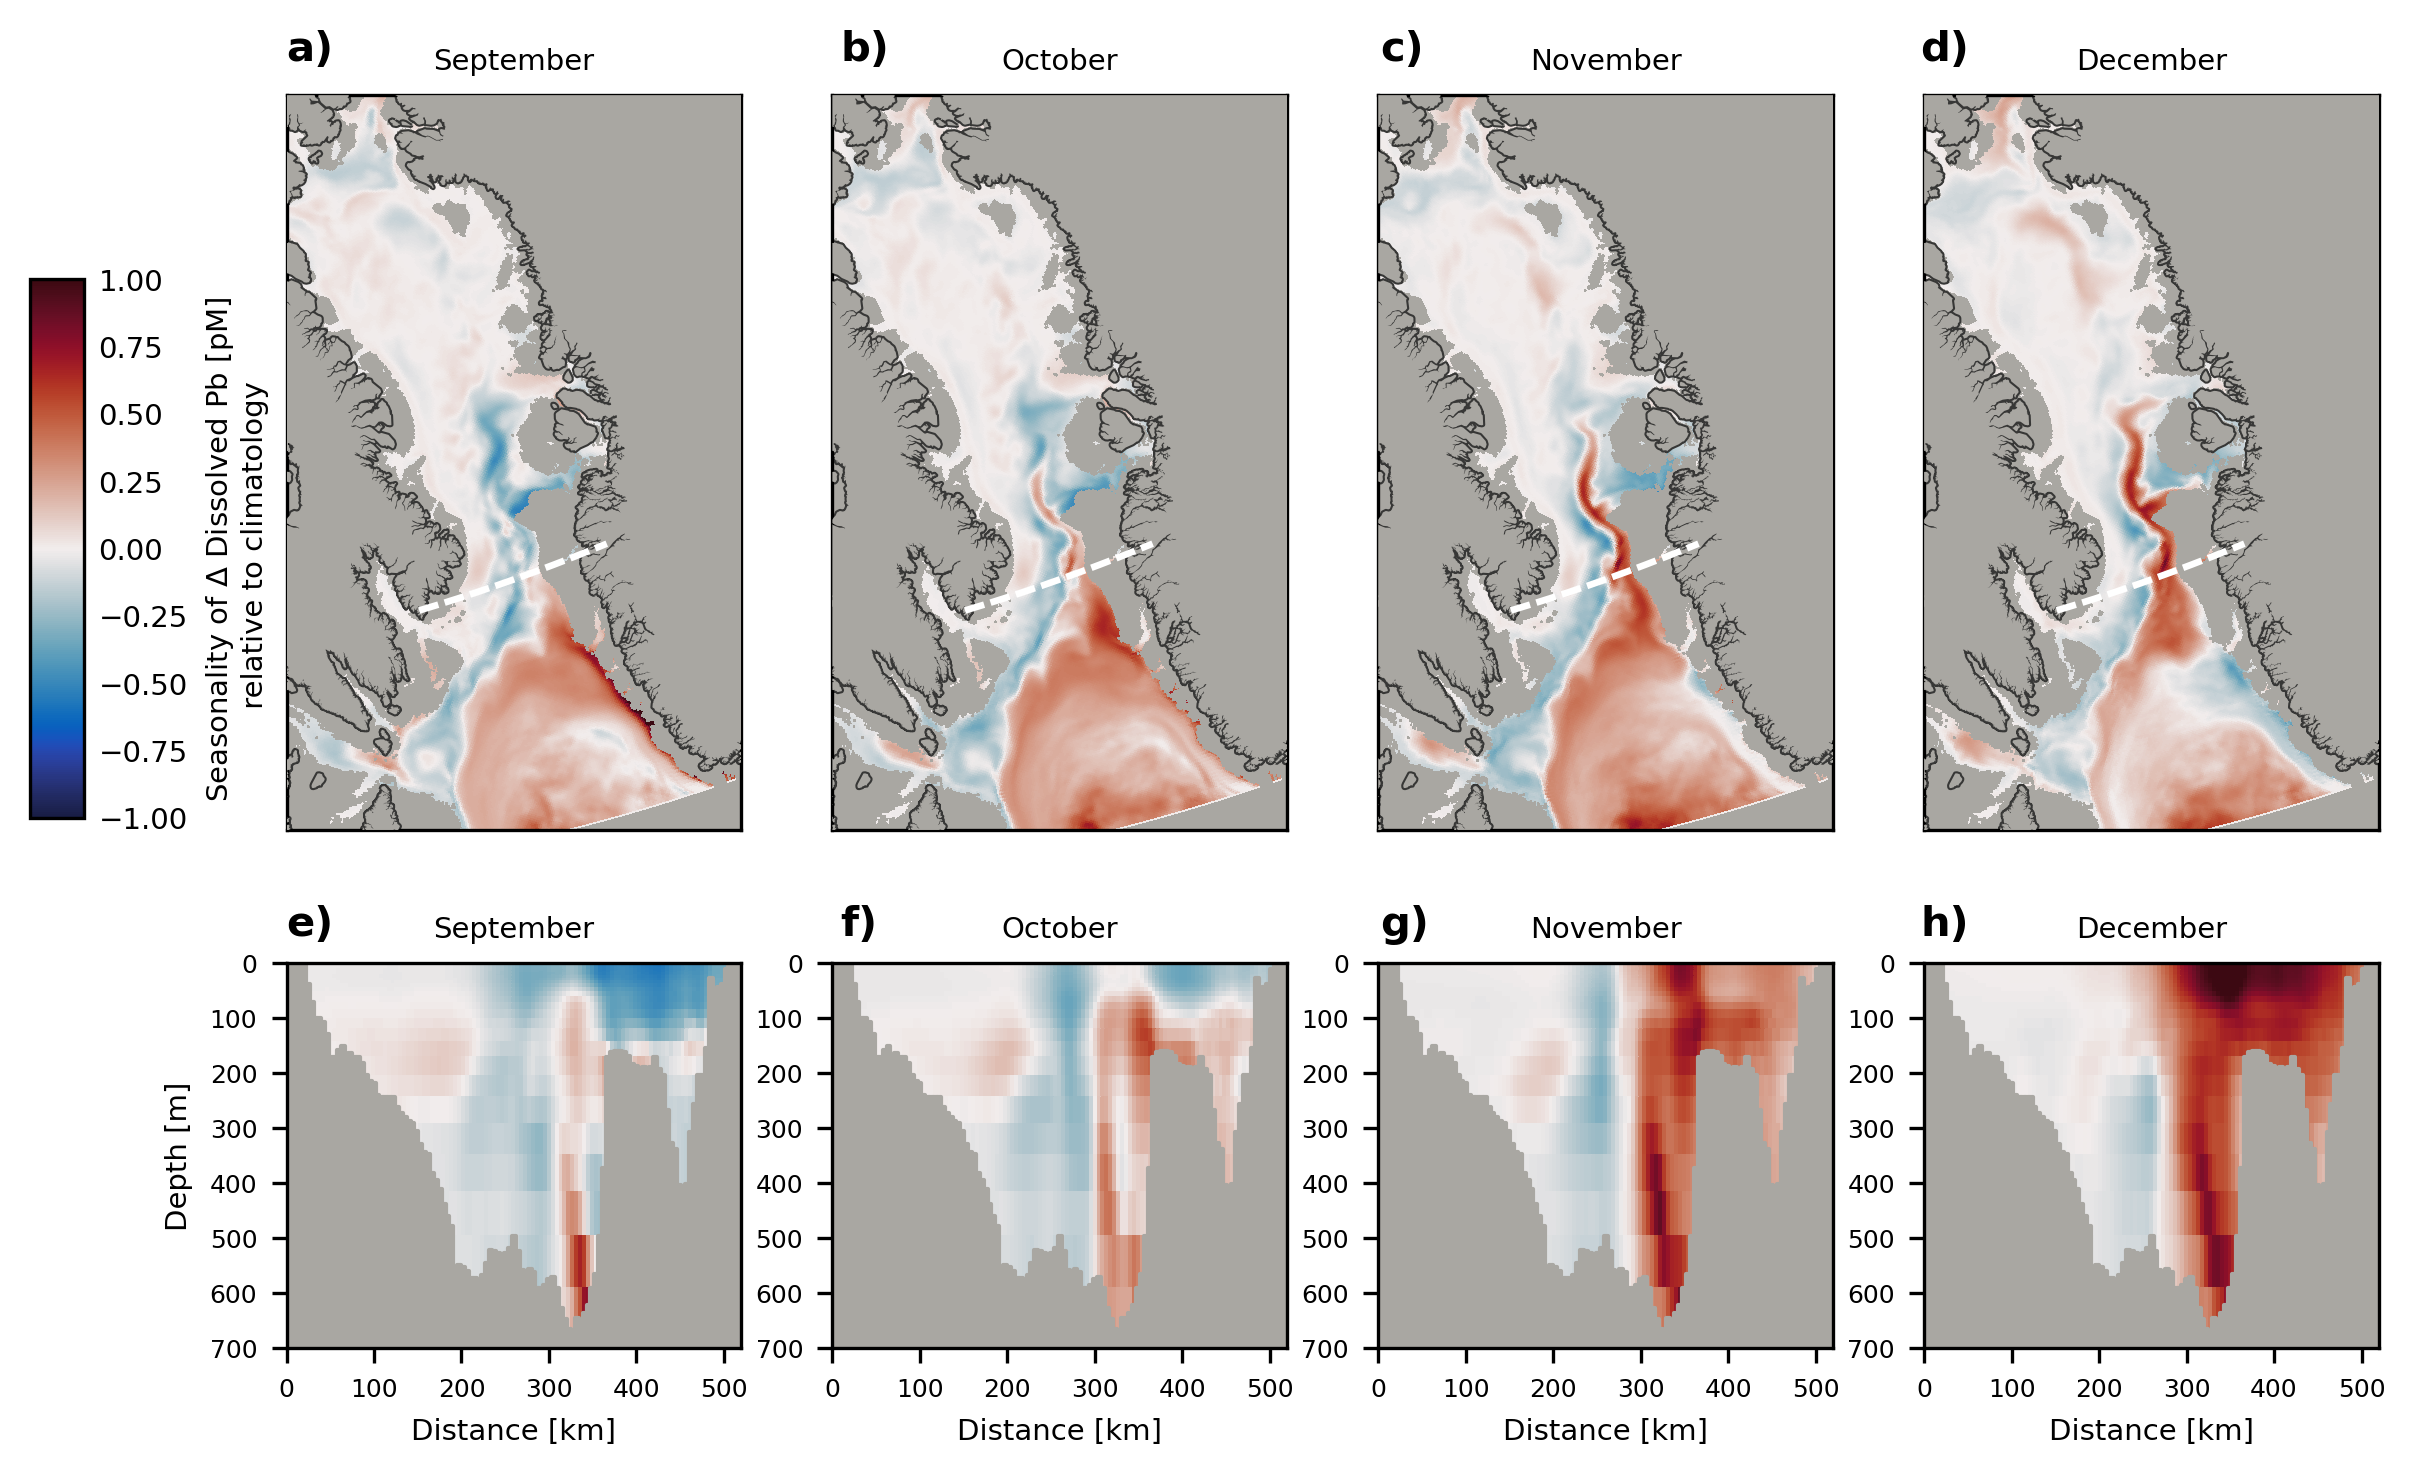

In [22]:
fig, ax = setup_figure(layer=27)

xx, zz = np.meshgrid(DS_distance, mesh_gdepw)
for n, mth in enumerate(range(9,13)):
    ref = dPb_ref[mth-1,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
    LS  = dPb_LS[mth-1,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
    ref_mean = dPb_ref[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
    LS_mean  = dPb_LS[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
    ax[1,n].set_title(f'{full_month_list[mth-1]}', fontsize=7)
    
    CB1 = ax[1,n].pcolormesh(xx, zz, ((LS-ref)-(LS_mean-ref_mean))*1e12, vmin=-1, vmax=1, cmap=cmap1)
    DS_patch = land_patch(DS_distance, DS_coords[0], DS_coords[2])
    ax[1,n].add_collection(DS_patch)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/R7-jet.jpg', dpi=300, bbox_inches='tight')

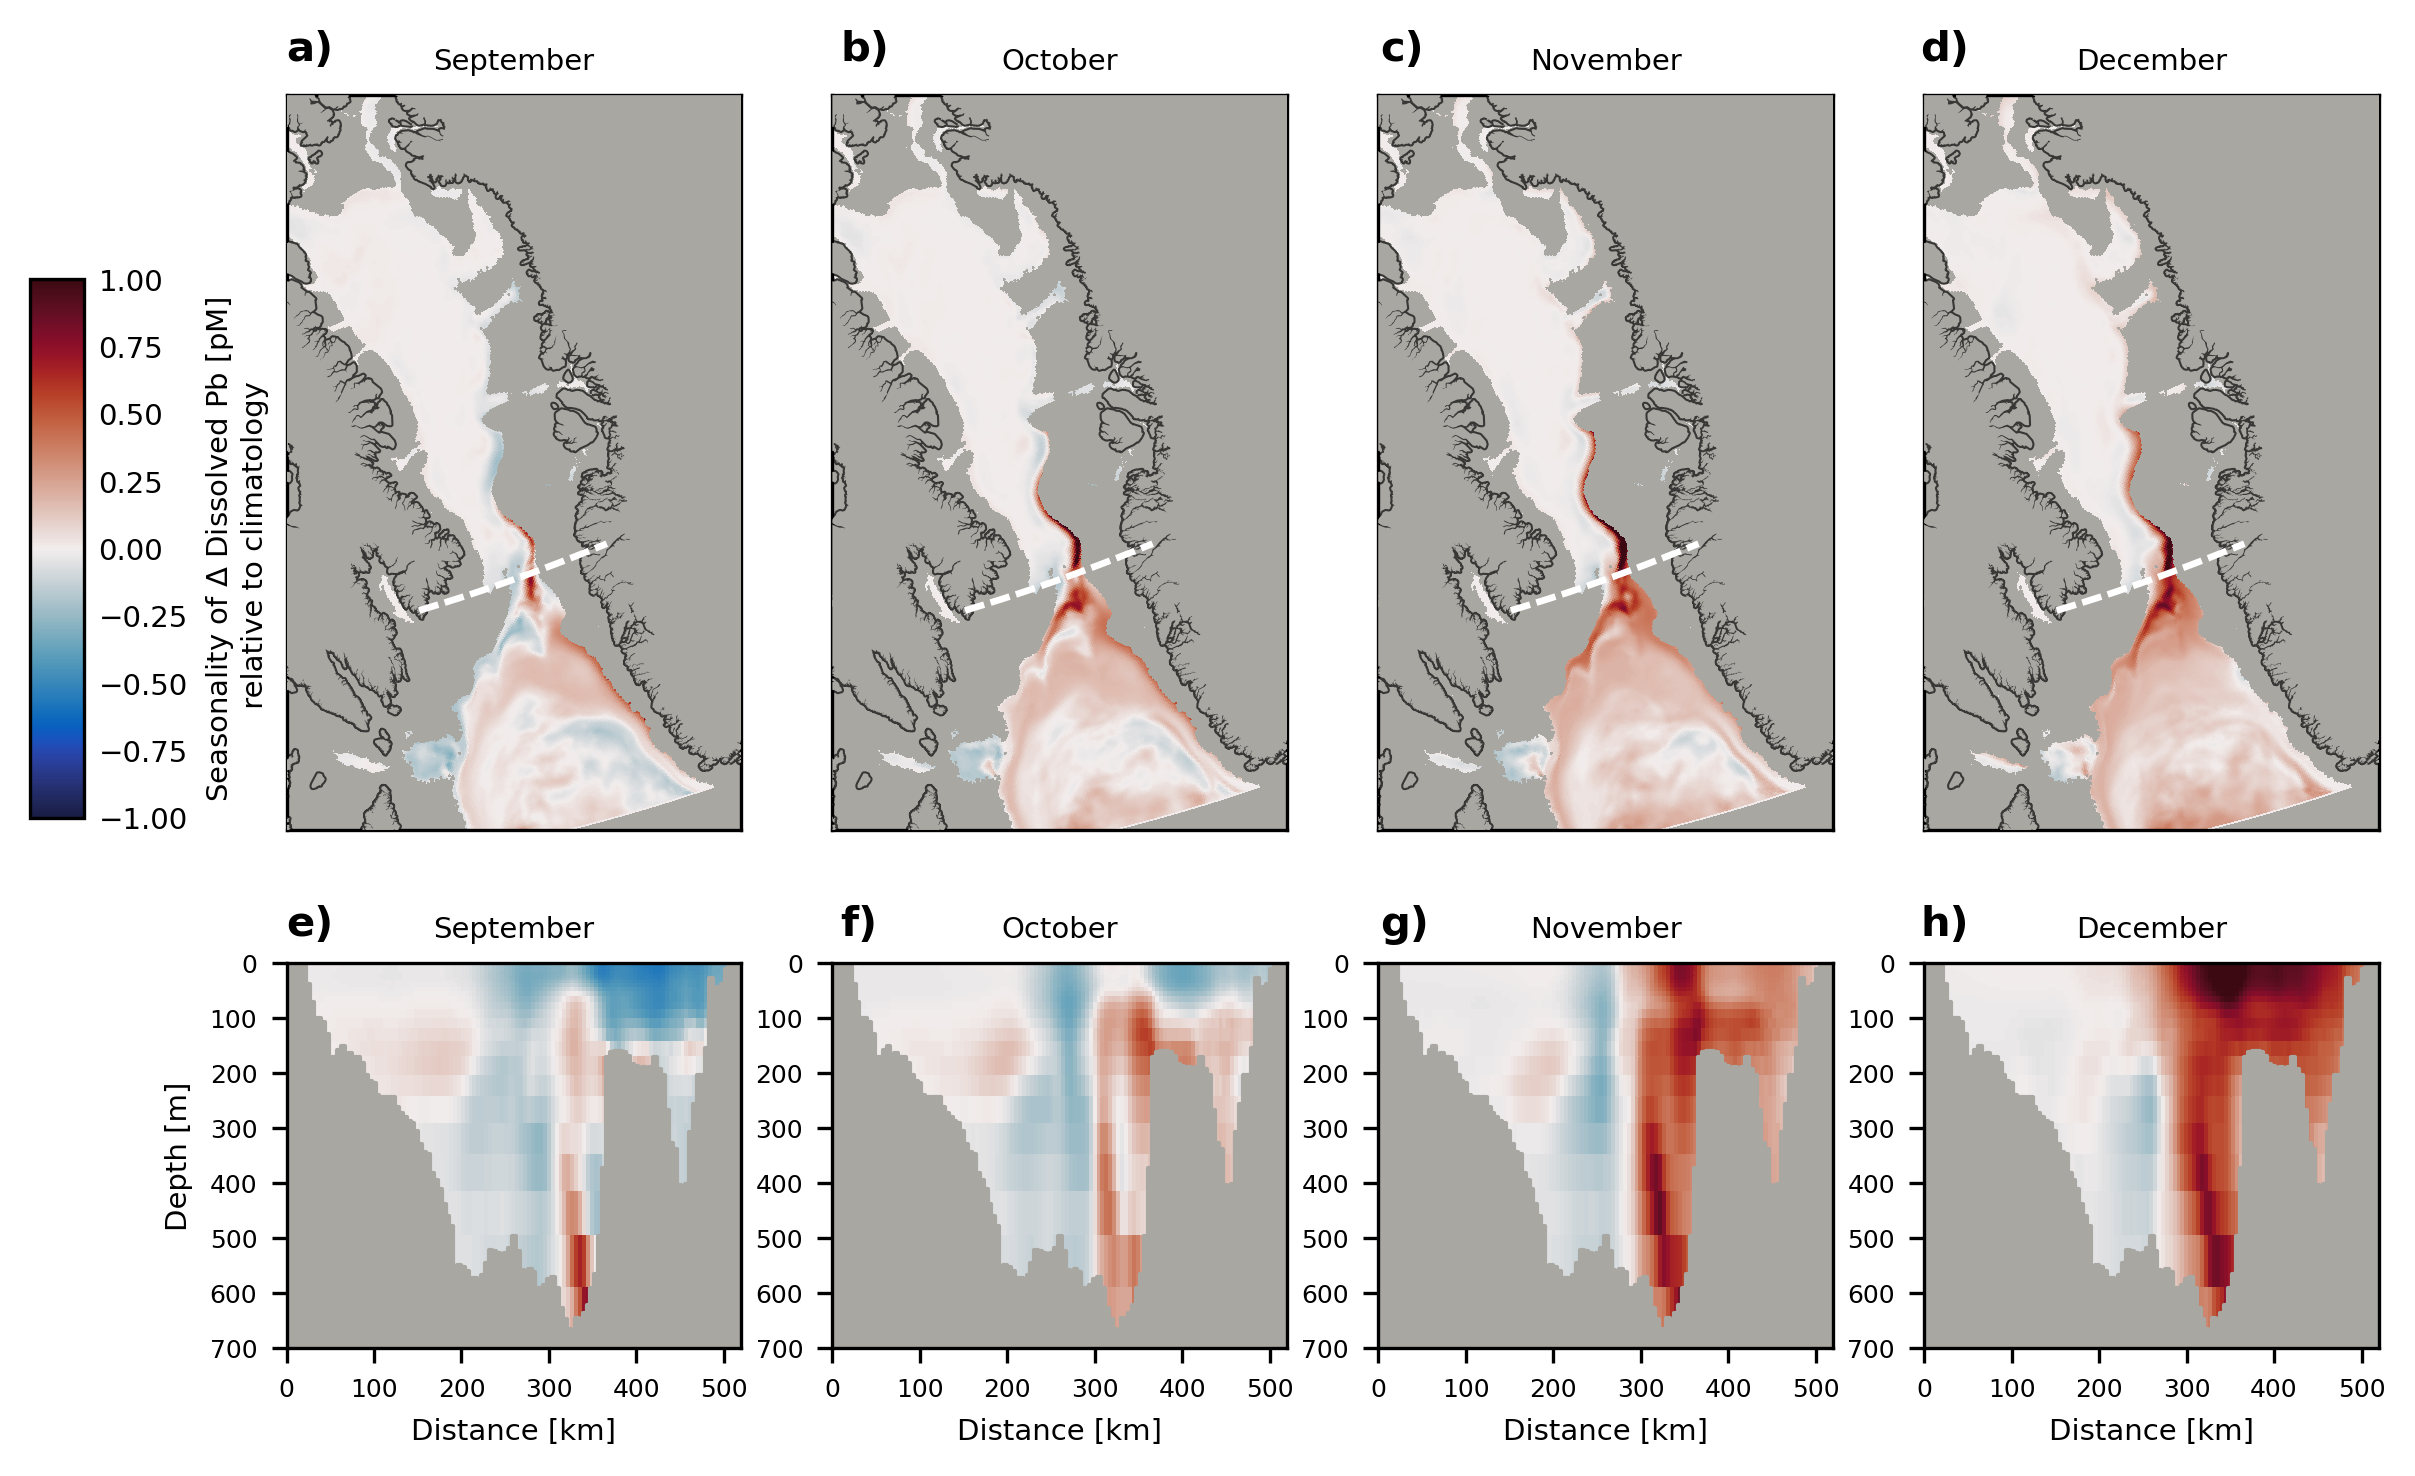

In [23]:
fig, ax = setup_figure(layer=31)

xx, zz = np.meshgrid(DS_distance, mesh_gdepw)
for n, mth in enumerate(range(9,13)):
    ref = dPb_ref[mth-1,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
    LS  = dPb_LS[mth-1,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
    ref_mean = dPb_ref[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
    LS_mean  = dPb_LS[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
    ax[1,n].set_title(f'{full_month_list[mth-1]}', fontsize=7)
    
    CB1 = ax[1,n].pcolormesh(xx, zz, ((LS-ref)-(LS_mean-ref_mean))*1e12, vmin=-1, vmax=1, cmap=cmap1)
    DS_patch = land_patch(DS_distance, DS_coords[0], DS_coords[2])
    ax[1,n].add_collection(DS_patch)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/S9-deeper-jet.jpg', dpi=300, bbox_inches='tight')

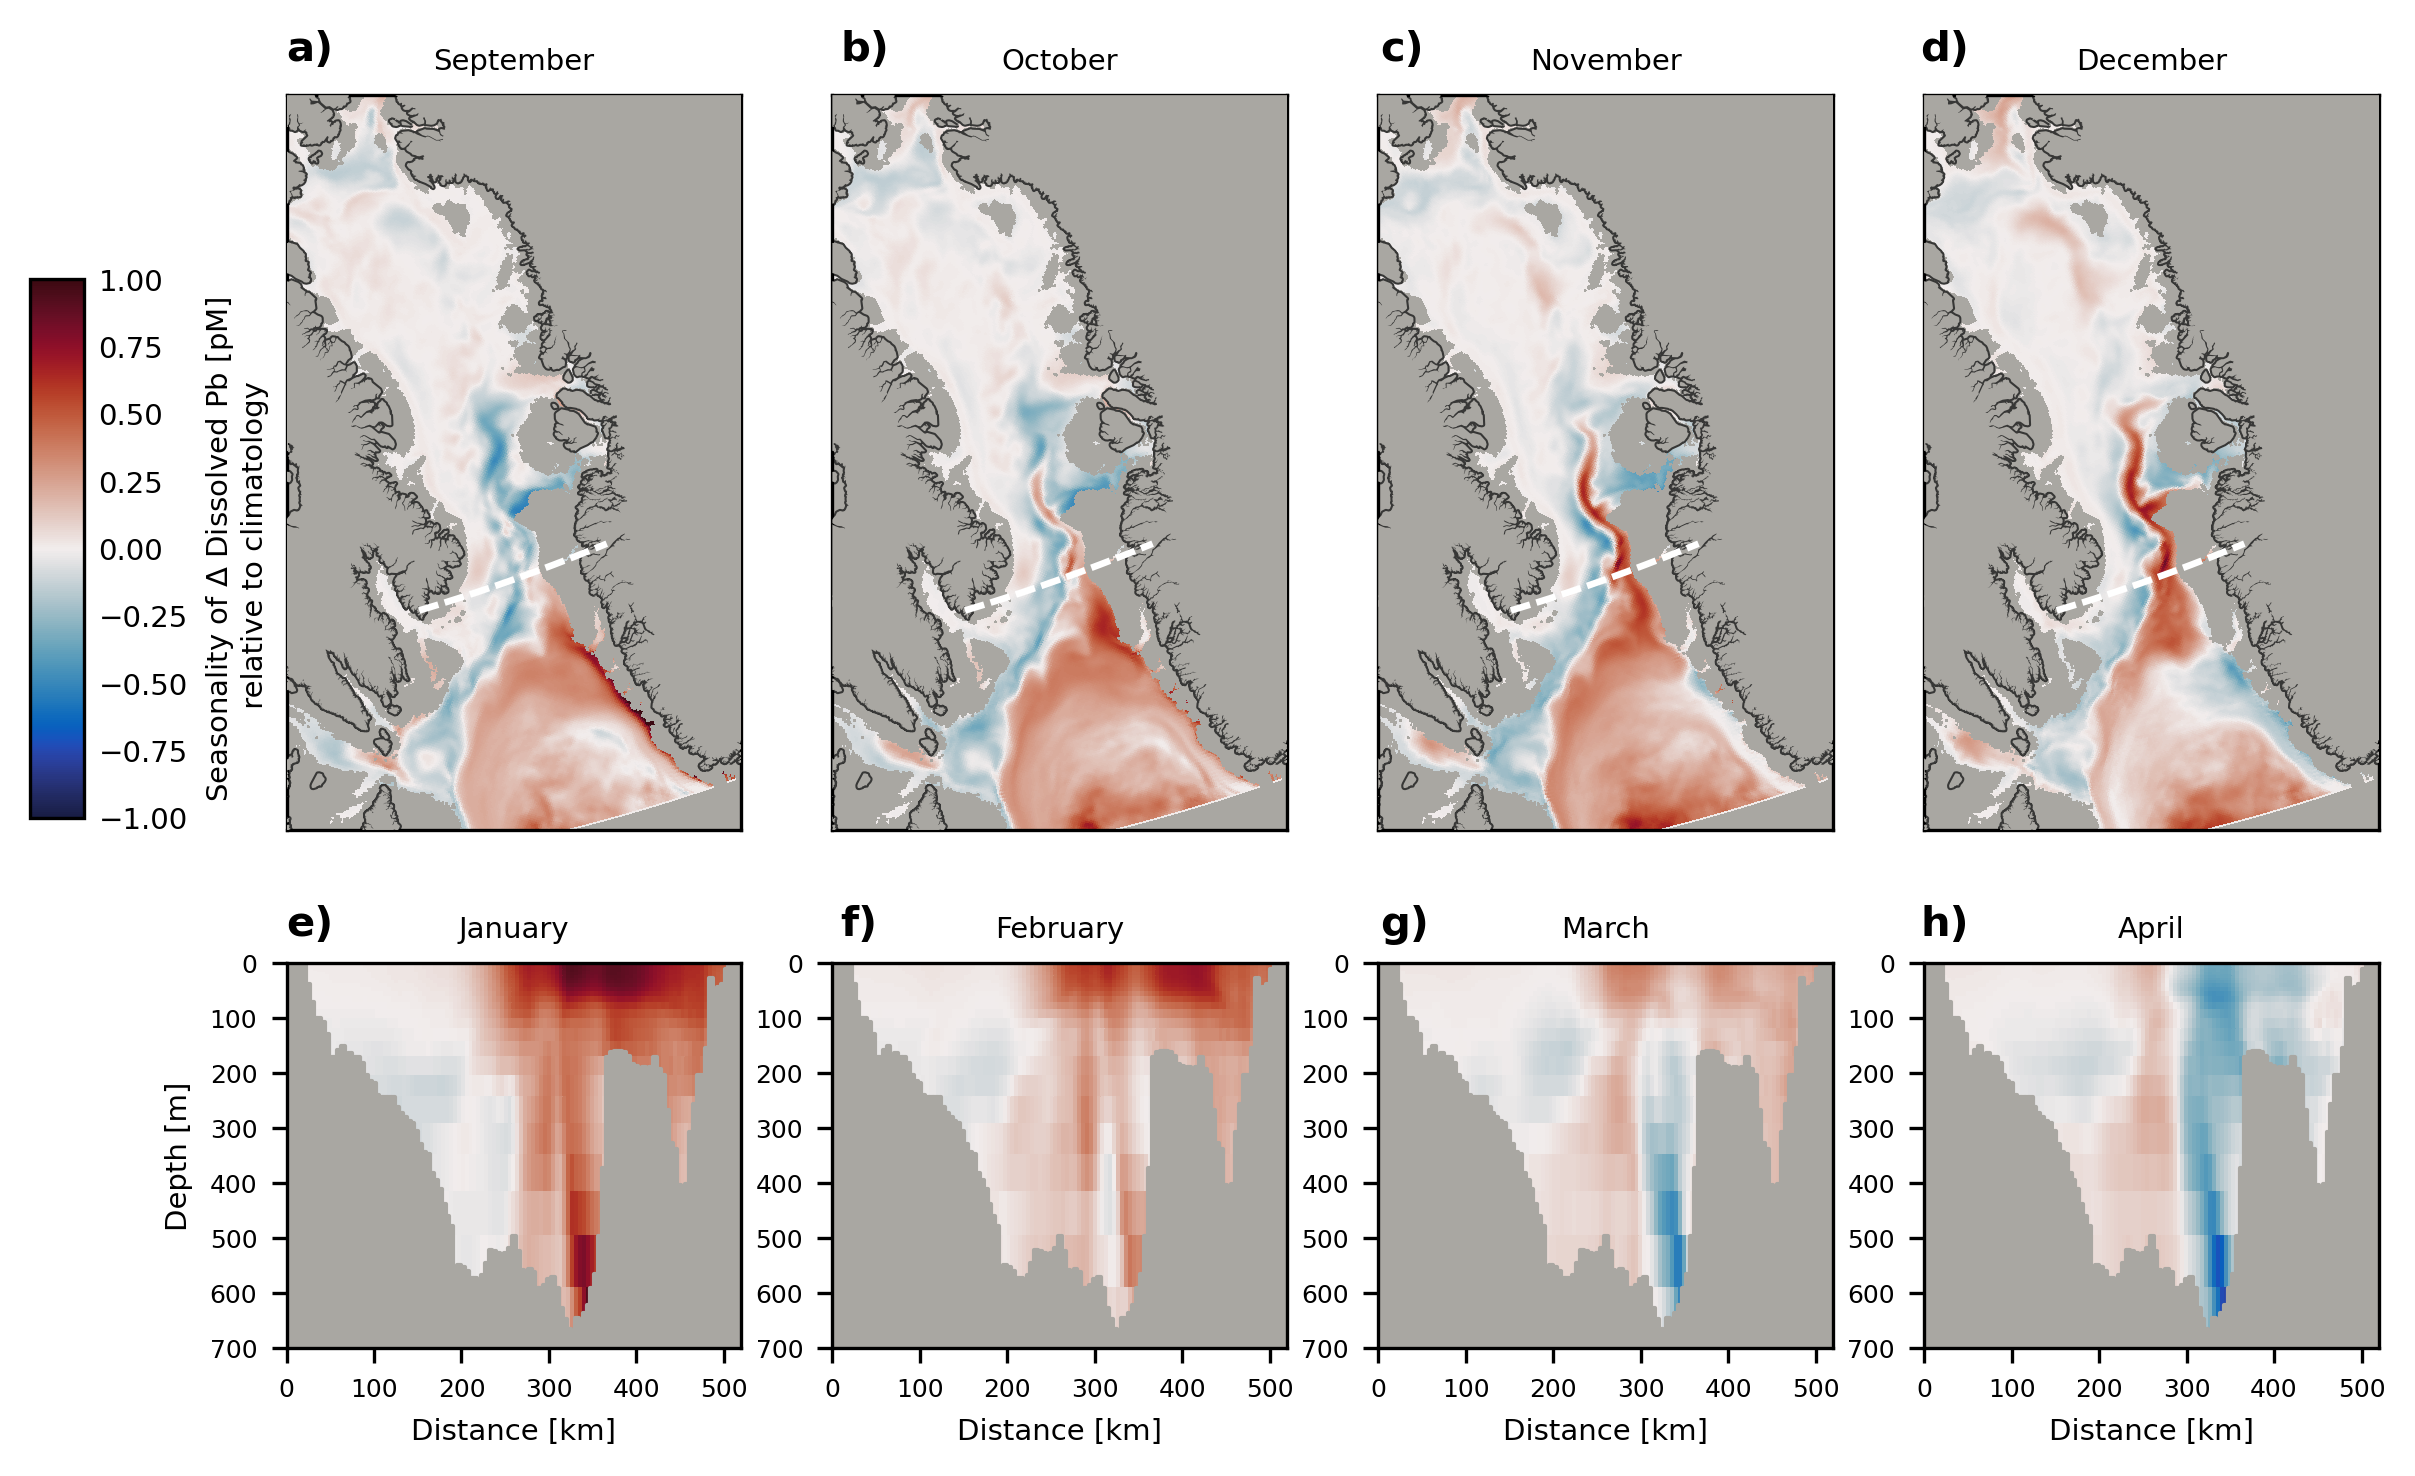

In [24]:
fig, ax = setup_figure(layer=27)

xx, zz = np.meshgrid(DS_distance, mesh_gdepw)
for n, mth in enumerate(range(1,5)):
    ref = dPb_ref[mth-1,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
    LS  = dPb_LS[mth-1,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
    ref_mean = dPb_ref[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
    LS_mean  = dPb_LS[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
    ax[1,n].set_title(f'{full_month_list[mth-1]}', fontsize=7)
    
    CB1 = ax[1,n].pcolormesh(xx, zz, ((LS-ref)-(LS_mean-ref_mean))*1e12, vmin=-1, vmax=1, cmap=cmap1)
    DS_patch = land_patch(DS_distance, DS_coords[0], DS_coords[2])
    ax[1,n].add_collection(DS_patch)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/S10-jet-month1-4.jpg', dpi=300, bbox_inches='tight')